# Sea surface currents (SSC) prediction from Himawari-8/9 SST 

Using the Gaussian Process method of de Kreij et al., 2025.

### In this tutorial:
1. Download and preprocess Himawari-8/9 SST data
2. View the SST data and spatial and temporal gradients
3. Perform Gaussian Process regression and inspect the hyper-parameter results
4. View the surface current predictions and uncertainties

Only a single prediction time step is shwon in this tutorial. To process many time steps see tutorial 3. 

In [1]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from inversion_sst_gp import plots
from inversion_sst_gp import gp_regression as gpr
from inversion_sst_gp.download import himawari
from inversion_sst_gp import utils

%matplotlib inline

/home/wedge/anaconda3/envs/sstinv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Download himawari data

##### Set geographical limits and chose a time step

*Note that ~3 x 3 degree boxes are a recommended maximum area for reasonable processing on personal computers.*

In [2]:
# Define geographical and temporal boundaries for data processing
LON_LIMITS = (122.45, 123.75)
LAT_LIMITS = (-14.5, -13.3)  
ll_box = (LON_LIMITS, LAT_LIMITS)

# Set the time bounds - predictions will be done hourly within these limits
time_lims = ["2024-06-01T00:00:00", "2024-10-01T00:00:00"]

crop_app = 'browse_basin_winter24'

# Set the save directory for the data (recommend this directory is ignored by git if inside the repo)
base_dir = os.path.join('/mnt', 'd', 'Work_backup', 'C_drive', 'Large_Data')
alldata_dir = os.path.join(base_dir, 'Other', 'Himawari', 'all')
cropped_dir = os.path.join(base_dir, 'Other', 'Himawari', crop_app)

##### Retrieve the required complete Himawari data files

Some files don't exist on the server. These timesteps will not get a velocity prediction.

In [3]:
# # Download the data
# himawari.get_sst_series_nasa(time_lims, alldata_dir)

In [4]:
# ### Crop himawari files (optional)

# # Setting ow=True will delete the original files after cropping (can also just set file_app='')
# himawari.crop_sst_series_nasa(alldata_dir, time_lims, ll_box, file_app=crop_app, overwrite=False)

In [5]:
# # Move the new files to another folder
# move_files = glob.glob(os.path.join(alldata_dir, f'*{crop_app}.nc'))
# for mf in move_files:
#     f_name = os.path.split(mf)[1]
#     shutil.move(mf, os.path.join(cropped_dir, f_name))

In [6]:
# # Load the data
# ds = himawari.process_sst_series(alldata_dir, time_lims, ll_box, file_app=crop_app, sst_reduce=2)
# ds

In [8]:
# ### Optional: save joined DS and delete individual cropped files
# ds.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app}_compiled.nc'))
ds = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_compiled.nc'))

---
# Run the parameter optimization

##### Running on the first time step only

This is acceptable for short time series where it is expected that the hyper-parameters do not change significantly over time.

In [9]:
# Set model hyperparameters
prop_sat = gpr.get_default_params()

# Run model
print("Running GP optimization")

# Set the time interval for refitting hyperparameters - if this is less than 1 hr, refitting will occur at every time step
refit_time = np.timedelta64(10, 'h').astype('timedelta64[ns]')

# results_step = gpr.fit_series(ds, prop_sat, refit_time, save_steps=True, save_name=os.path.join(cropped_dir, f'{crop_app}_fits_10h.nc'), callback='off', coverage=0.8)

Running GP optimization


In [10]:
### Load the results
ds_results = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_fits_10h.nc'))
ds_results.close()
ds_results

<xarray.Dataset> Size: 256kB
Dimensions:    (time: 2911)
Coordinates:
  * time       (time) datetime64[ns] 23kB 2024-06-01 ... 2024-09-30T23:00:00
Data variables:
    sigma_u    (time) float64 23kB ...
    l_u        (time) float64 23kB ...
    tau_u      (time) float64 23kB ...
    sigma_v    (time) float64 23kB ...
    l_v        (time) float64 23kB ...
    tau_v      (time) float64 23kB ...
    sigma_S    (time) float64 23kB ...
    l_S        (time) float64 23kB ...
    tau_S      (time) float64 23kB ...
    sigma_tau  (time) float64 23kB ...

In [11]:
## Use parameters to make predictions
print("Calculating GP regression prediction")
# ds_full = gpr.predict_series(ds.sel(time=ds_results.time), ds_results)
# ds_full.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app}_predictions_10h.nc'))

### Load the data
ds_full = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_predictions_10h.nc'))

Calculating GP regression prediction


In [12]:
ds_restrim = ds_results.copy()
ds_restrim = ds_restrim.dropna(dim='time')

# This removes repeated parameters so we can just see where the fits were done
ds_restrim = utils.clean_dataset(ds_restrim)

# If you prefer to have nan instead of missing time steps
ds_full_hourly = utils.make_even_hourly(ds_full)
ds_restrim_hourly = utils.make_even_hourly(ds_restrim)

#### Plotting the parameter fits

The top plot shows u velocity predictions (line) plus the data coverage (scatter points).

The rest of the plots show the parameter fits plus the median value (dotted line). **You could use the median values for predictions if the values look stabble over time.**

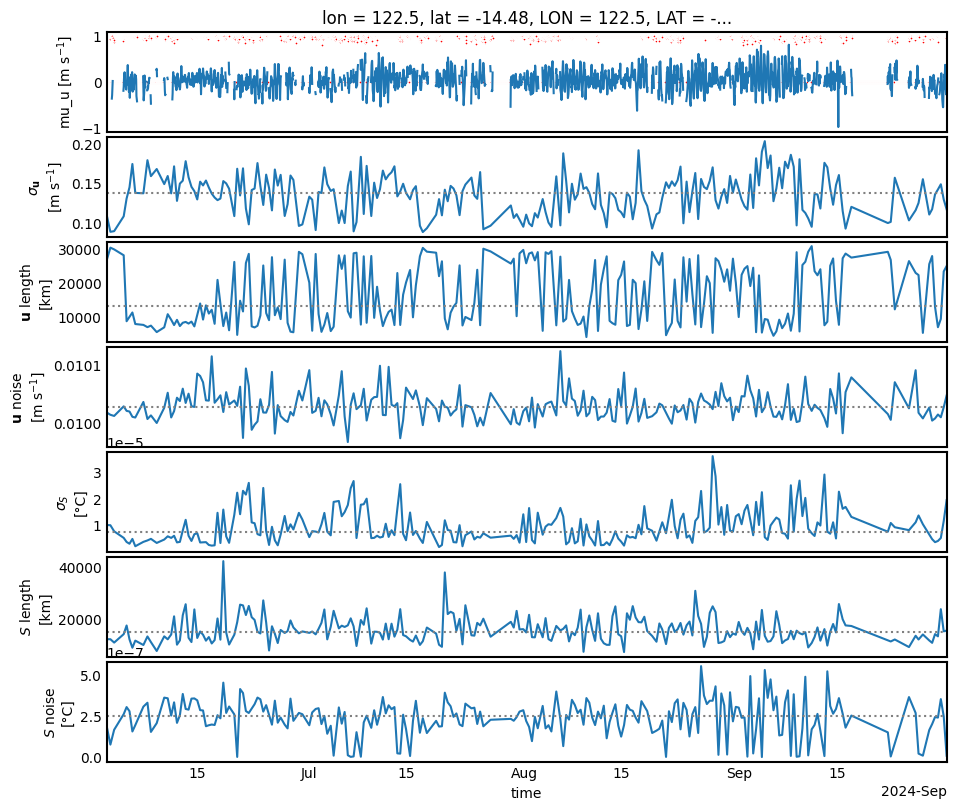

In [12]:
fig, ax = plots.plot_param_series(ds_restrim, ds_full_hourly)

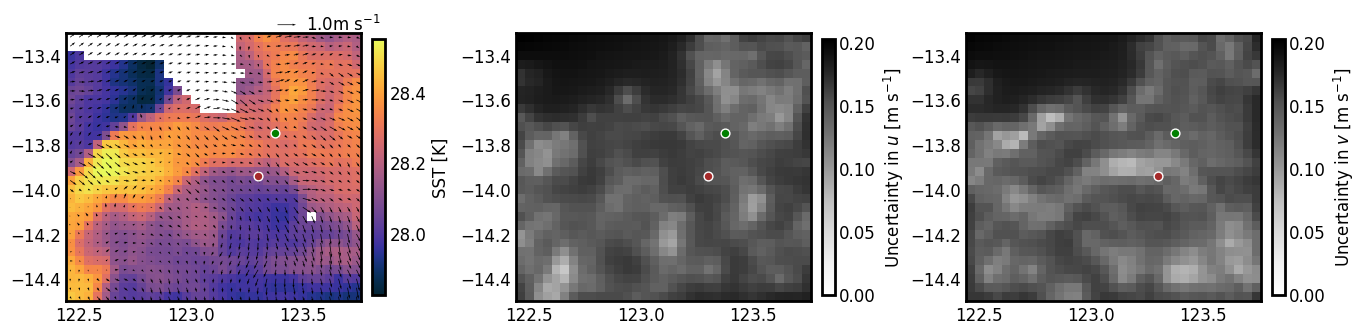

In [29]:
fig, ax = plots.plot_prediction(ds_full_hourly.sel(time='2024-06-11T14'), qv_scale=16, qk_size=1.)

# Add Prelude
prelude = (123.3744, -13.74942)

# Add Ichthys
ichthys = (123.29777777, -13.93958000)

for x in ax:
    x.scatter(prelude[0], prelude[1], c='green', ec='w', s=40)
    x.scatter(ichthys[0], ichthys[1], c='brown', ec='w', s=40)

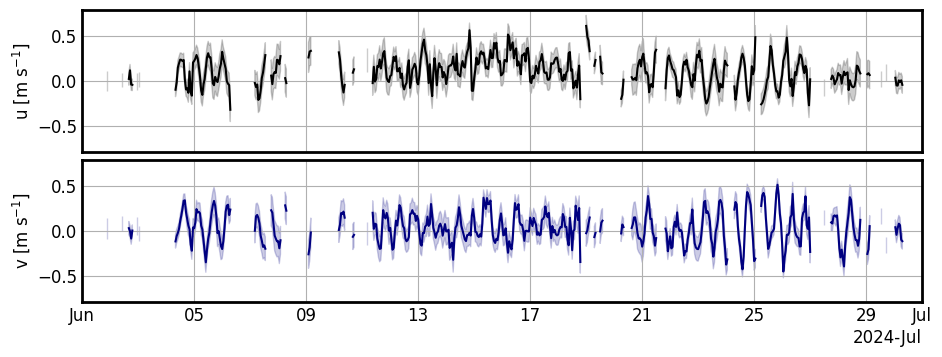

In [30]:
fig, ax = plots.plot_timeseries(ds_full_hourly, lon_pt=prelude[0], lat_pt=prelude[1])
for x in ax:
    x.set_ylim(-0.79,0.79)
    x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[0]) + np.timedelta64(30,'D'))

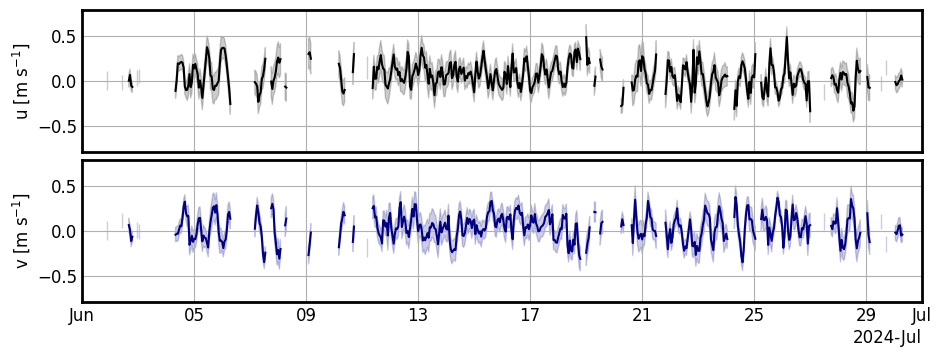

In [31]:
fig, ax = plots.plot_timeseries(ds_full_hourly, lon_pt=ichthys[0], lat_pt=ichthys[1])
for x in ax:
    x.set_ylim(-0.79,0.79)
    x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[0]) + np.timedelta64(30,'D'))

# Analysis

#### Some functions below may not be generally accessible

Ask us for details. 

First, plot the barotropic tide at each site

In [32]:
from ichthys_harmonics.harmonic_funcs import rotate_predictions
from ichthys_harmonics.utils import create_time
from ichthys_harmonics.harmonic_lstsq import load_tide_predictions
from ichthys_harmonics.plotfuncs import plot_decomposed_currents, plot_combined_currents, plot_speed

In [19]:
moor = 'Fblock'
# moor = 'Ichthys_CPF'

# Find data
nc_dir = os.path.join('../', '../', '../', '../', '../', 'wedge', 'ichthys_harmonics', 'fits')

# Set the load order (don't change)
order = ['BTNS', 'BTEW', 'ITNS', 'ITEW']

time_pred = create_time(np.datetime64(time_lims[0]), np.datetime64(time_lims[1]), step_minutes=60)

ds_tide = load_tide_predictions(time_pred, nc_dir, moor, order)

# Rotate the predictions
ds_tide = rotate_predictions(ds_tide)

/home/wedge/anaconda3/envs/sstinv/lib/python3.12/site-packages/xarray/namedarray/core.py:261: UserWarning: Duplicate dimension names present: dimensions {'coef'} appear more than once in dims=('coef', 'coef'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  self._dims = self._parse_dimensions(dims)
/home/wedge/anaconda3/envs/sstinv/lib/python3.12/site-packages/xarray/namedarray/core.py:261: UserWarning: Duplicate dimension names present: dimensions {'coef'} appear more than once in dims=('coef', 'coef'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarra

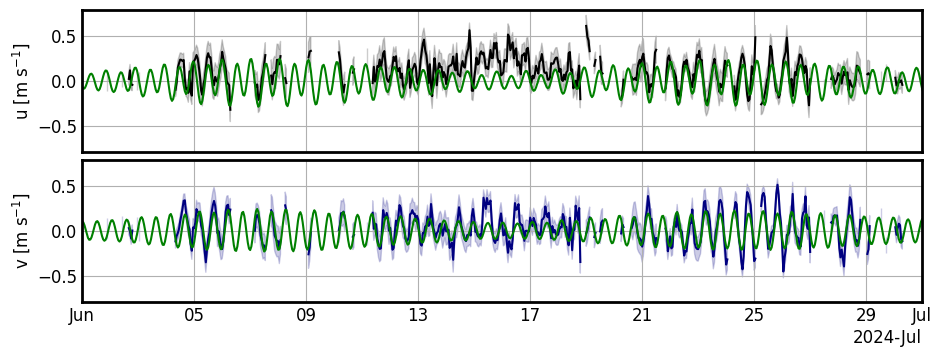

In [22]:
fig, ax = plots.plot_timeseries(ds_full_hourly, lon_pt=prelude[0], lat_pt=prelude[1])

ax[0].plot(ds_tide.time, ds_tide['BTEW'], c='green')
ax[1].plot(ds_tide.time, ds_tide['BTNS'], c='green')

for x in ax:
    x.set_ylim(-0.79,0.79)
    x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[0]) + np.timedelta64(30,'D'))


## Load and plot the DWR mooring

In [21]:
import os
import pIMOS.utils.catalogue as pcat

# Load the DWR data
exp = 'Shell'
moor = 'DWR'
exp_base = os.path.join(base_dir, 'Industry', exp, 'data', 'moored_instrument_data')

cat = pcat.get_pimos_catalogue(exp_base, is_moored=True)

# Load the most recent DWR file
ds_dwr = xr.open_dataset(cat['nc_path'].loc[cat['Group']==moor].values[-1], decode_times=True)
ds_dwr

INITIALISING pIMOS
Need to update dolfyn to version 1
pyODAS not found, not importing pIMOS.xrwrap.rsi_vmp
Looking for pimos_v1.1.1 within /mnt/d/Work_backup/C_drive/Large_Data/Industry/Shell/data/moored_instrument_data
.... pimos_v1.1.1 found
FV01


<xarray.Dataset> Size: 4MB
Dimensions:               (time: 26455)
Coordinates:
  * time                  (time) datetime64[ns] 212kB 2024-01-31T10:00:00 ......
    lat_nom               float64 8B ...
    lon_nom               float64 8B ...
    z_nom                 float64 8B ...
Data variables: (12/23)
    current_speed         (time) float32 106kB ...
    qc_current_speed      (time) float64 212kB ...
    current_direction     (time) float32 106kB ...
    qc_current_direction  (time) float64 212kB ...
    SigmaCurSpd           (time) float32 106kB ...
    qc_SigmaCurSpd        (time) float64 212kB ...
    ...                    ...
    qc_MeanCurVertComp    (time) float64 212kB ...
    SigmaCurVertComp      (time) float32 106kB ...
    qc_SigmaCurVertComp   (time) float64 212kB ...
    east_vel              (time) float32 106kB ...
    north_vel             (time) float32 106kB ...
    qc_velocity           (time) float32 106kB ...
Attributes: (12/35)
    title:                           Measured data parsed from an RPS data file.
    institution:                     The University of Western Australia
    institution_division:            Ocean Dynamics
    source:                          pIMOS RPS
    project:                         Prelude
    history:                         2024-08-12 14:16:45 [AFS] 2024-08-12 14:...
    ...                              ...
    nominal_instrument_height_asb:   250.35
    nominal_instrument_orientation:  
    timezone:                        
    process_level:                   1
    is_profile_data:                 0
    pimos_nickname:                  DWR

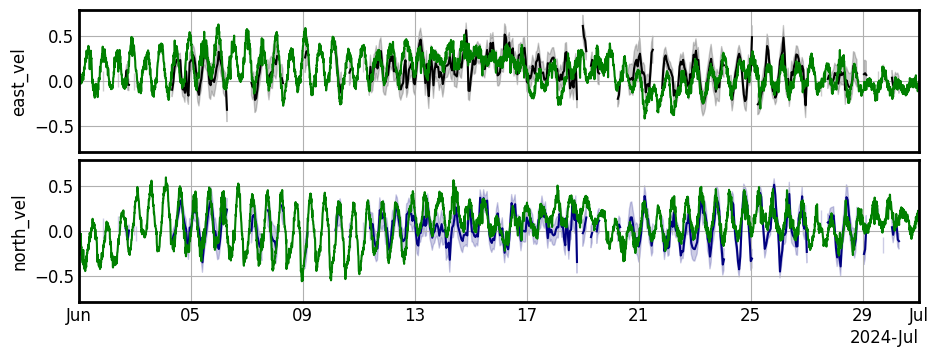

In [23]:
fig, ax = plots.plot_timeseries(ds_full_hourly, lon_pt=prelude[0], lat_pt=prelude[1])

ds_dwr['east_vel'].plot(ax=ax[0], c='g')
ds_dwr['north_vel'].plot(ax=ax[1], c='g')

for x in ax:
    x.set_ylim(-0.79,0.79)
    x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[0]) + np.timedelta64(30,'D'))
    x.set_title('')
    x.set_xlabel('')
_=ax[0].set_xticklabels([])

In [27]:
def rmse(a, b):
    return np.sqrt(np.nanmean((a - b)**2))

pred_nan = ~np.isnan(ds_full_hourly['mu_u'].sel(lon=prelude[0], lat=prelude[1], method='nearest'))

dwr_east_int = ds_dwr['east_vel'].interp(time=ds_full_hourly['time'], method='nearest')
dwr_north_int = ds_dwr['north_vel'].interp(time=ds_full_hourly['time'], method='nearest')

print('RMSE east vel: ', rmse(ds_full_hourly['mu_u'].sel(lon=123.3744, lat=-13.74942, method='nearest').where(pred_nan), dwr_east_int.where(pred_nan)))
print('RMSE north vel: ', rmse(ds_full_hourly['mu_v'].sel(lon=123.3744, lat=-13.74942, method='nearest').where(pred_nan), dwr_north_int.where(pred_nan)))

dwr_nan = ~np.isnan(dwr_east_int.values)
all_nan = pred_nan & dwr_nan
print('Corr east vel: ', np.corrcoef(ds_full_hourly['mu_u'].sel(lon=123.3744, lat=-13.74942, method='nearest').where(all_nan, drop=True), dwr_east_int.where(all_nan, drop=True))[0,1])
print('Corr north vel: ', np.corrcoef(ds_full_hourly['mu_v'].sel(lon=123.3744, lat=-13.74942, method='nearest').where(all_nan, drop=True), dwr_north_int.where(all_nan, drop=True))[0,1])

RMSE east vel:  0.1497762236859911
RMSE north vel:  0.14913727445054506
Corr east vel:  0.5548214849955403
Corr north vel:  0.5738338471032846


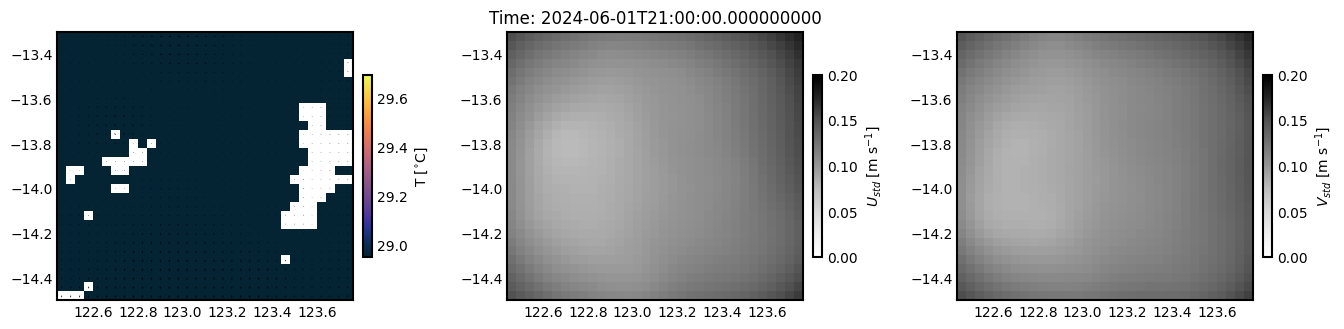

In [14]:
# from IPython.display import HTML
# %matplotlib notebook

ani = plots.plot_prediction_animation(ds_full, qv_scale=20, anim_interval=120, smoothing=0.05, add_cbar=True)
ani.save(f'{crop_app}_animation_full.mp4')
# HTML(ani.to_jshtml())